In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

In [2]:
plt.style.use("ggplot")

In [3]:
writer = SummaryWriter("runs/mnist2")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
training_dataset = torchvision.datasets.MNIST(root = "./data",
                                              train = True,
                                              transform = transforms.ToTensor(),
                                              download = True)

test_dataset = torchvision.datasets.MNIST(root = "./data",
                                              train = False,
                                              transform = transforms.ToTensor(),
                                              download = True)

In [6]:
batch_size = 100

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)

In [8]:
print(f"There are total {len(train_loader)} batches in our training dataset with each batch of size {batch_size}, so there are total of {len(train_loader) * batch_size} samples")
print(f"There are total {len(test_loader)} batches in our testing dataset with each batch of size {batch_size}, so there are total of {len(test_loader) * batch_size} samples")

There are total 600 batches in our training dataset with each batch of size 100, so there are total of 60000 samples
There are total 100 batches in our testing dataset with each batch of size 100, so there are total of 10000 samples


In [9]:
examples = iter(train_loader)

In [10]:
examples_data, examples_targets = next(examples)

In [11]:
examples_data.shape, examples_targets.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

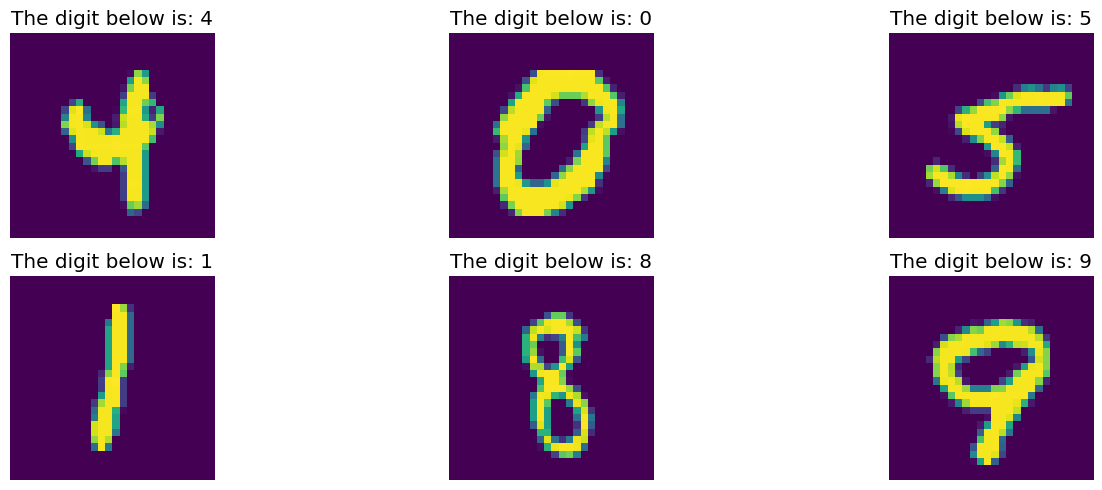

In [12]:
plt.figure(figsize = (15, 5))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(examples_data[i][0])
    plt.title(f"The digit below is: {examples_targets[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
images_grid = torchvision.utils.make_grid(examples_data)

In [14]:
writer.add_image("MNIST Images", images_grid)
writer.close()

In [15]:
input_size = 784
hidden_size = 100
num_classes = 10

In [16]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        output = self.linear1(x)
        output = self.relu(output)
        output = self.linear2(output)
        return output

In [17]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [18]:
writer.add_graph(model, examples_data.view(-1, input_size))
writer.close()  

In [19]:
learning_rate = 0.01

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [21]:
epochs = 3
n_total_steps = len(train_loader)

In [22]:
running_loss = 0.0
running_correct = 0

In [23]:
for epoch in range(1, epochs + 1):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        images_batch = images_batch.view(-1, input_size).to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        running_loss += loss.item()
        
        _, predictions = torch.max(outputs, 1)
        
        running_correct += (predictions == labels_batch).sum().item()
 
        if i % 100 == 0:
            print(f"Epoch # {epoch} / {epochs}, step # {i} / {n_total_steps}, loss: {loss:.3f}")
            writer.add_scalar("training loss", running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar("training accuracy", running_correct / 100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0
    print()

Epoch # 1 / 3, step # 0 / 600, loss: 2.306
Epoch # 1 / 3, step # 100 / 600, loss: 0.217
Epoch # 1 / 3, step # 200 / 600, loss: 0.214
Epoch # 1 / 3, step # 300 / 600, loss: 0.143
Epoch # 1 / 3, step # 400 / 600, loss: 0.155
Epoch # 1 / 3, step # 500 / 600, loss: 0.150

Epoch # 2 / 3, step # 0 / 600, loss: 0.138
Epoch # 2 / 3, step # 100 / 600, loss: 0.096
Epoch # 2 / 3, step # 200 / 600, loss: 0.075
Epoch # 2 / 3, step # 300 / 600, loss: 0.050
Epoch # 2 / 3, step # 400 / 600, loss: 0.094
Epoch # 2 / 3, step # 500 / 600, loss: 0.090

Epoch # 3 / 3, step # 0 / 600, loss: 0.058
Epoch # 3 / 3, step # 100 / 600, loss: 0.104
Epoch # 3 / 3, step # 200 / 600, loss: 0.206
Epoch # 3 / 3, step # 300 / 600, loss: 0.157
Epoch # 3 / 3, step # 400 / 600, loss: 0.071
Epoch # 3 / 3, step # 500 / 600, loss: 0.223



In [24]:
correct = 0
total = 0

class_predictions = []
class_labels = []

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.view(-1, input_size).to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        _, predictions = torch.max(outputs, 1)
        
        total += labels_batch.size(0)
        correct += (predictions == labels_batch).sum().item()

        class_predictions.append([F.softmax(output, dim = 0) for output in outputs])
        class_labels.append(labels_batch)

    class_predictions = torch.cat([torch.stack(predictions_batch, dim = 0) for predictions_batch in class_predictions], dim = 0)
    class_labels = torch.cat(class_labels, dim = 0)

accuracy = (correct / total) * 100

In [25]:
print(f'Test Accuracy: {accuracy:.3f}%')

Test Accuracy: 96.230%


In [26]:
class_predictions

tensor([[2.1028e-13, 1.3928e-08, 2.4439e-10,  ..., 9.9998e-01, 1.5537e-11,
         1.0337e-09],
        [1.3334e-12, 2.4495e-03, 9.9755e-01,  ..., 7.6721e-15, 4.5697e-14,
         2.0375e-23],
        [2.2747e-11, 9.9997e-01, 7.8142e-06,  ..., 5.5818e-06, 8.6358e-07,
         6.4601e-08],
        ...,
        [4.6558e-17, 1.2313e-09, 8.0538e-14,  ..., 1.4331e-08, 7.0642e-08,
         2.8482e-05],
        [5.8001e-12, 4.2133e-10, 1.0392e-16,  ..., 1.2304e-16, 2.5434e-07,
         6.1614e-18],
        [1.1805e-13, 4.4546e-18, 7.9070e-11,  ..., 4.5865e-18, 9.6672e-14,
         1.2309e-12]])

In [27]:
class_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

In [29]:
for i in range(10):
    labels_i = (class_labels == i)
    predictions_i = class_predictions[:, i]
    writer.add_pr_curve(str(i), labels_i, predictions_i, global_step = 0)
    writer.close()